In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 1.0
classifier_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 2
labels_per_class = 'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
print(datestring)

2020_07_30_12_35_42_906965


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
sort_mask = np.argsort(Y_train)
Y_train = Y_train[sort_mask]
X_train = X_train[sort_mask]

In [10]:
sort_mask

array([12830, 36210, 47551, ..., 30608, 30560, 24999])

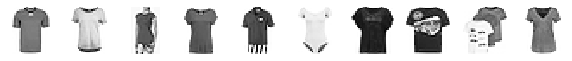

In [11]:
nex = 10
fig, axs = plt.subplots(ncols=nex, figsize=(nex, 1))
for i in range(1,nex+1):
    axs[i-1].matshow(np.squeeze(X_train[i]), cmap=plt.cm.Greys)
    axs[i-1].axis('off')

In [12]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [13]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [14]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)
umap_graph.nnz

884148

### Build data iterators

In [15]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [16]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [17]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

1000


In [18]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [19]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [20]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dropout(0.25))

In [21]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=128))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [22]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(128)))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [23]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Create UMAP object

In [24]:
#from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [25]:
import tensorflow as tf
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability
from tfumap.semisupervised import (
    find_a_b,
    compute_umap_loss,
    # compute_classifier_loss,
    batch_data,
)
import numpy as np
import os, tempfile
from tqdm.autonotebook import tqdm
from datetime import datetime


@tf.function
def compute_classifier_loss(X, y, encoder, classifier, sparse_ce, acc_func):
    """ compute the cross entropy loss for classification
        """
    d = classifier(encoder(X))
    loss = sparse_ce(y, d)
    acc = acc_func(y, d)
    return loss, acc


class PUMAP(tf.keras.Model):
    def __init__(
        self,
        encoder,
        embedder,
        classifier,
        tensorboard_logdir=None,  # directory for tensorboard log
        min_dist=0.1,
        negative_sample_rate=5.0,
        optimizer=tf.keras.optimizers.SGD(0.1),
        repulsion_strength=1.0,
        classifier_prop=1.0,
        umap_prop=1.0,  # to what extent do we train UMAP
        # ** kwargs,
    ):
        super(PUMAP, self).__init__()
        # self.__dict__.update(kwargs)

        # subnetworks
        self.embedder = embedder
        self.encoder = encoder
        self.classifier = classifier

        self.umap_prop = umap_prop
        self.classifier_prop = classifier_prop

        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.repulsion_strength = repulsion_strength
        self.negative_sample_rate = negative_sample_rate

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.class_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        self.class_acc_val = tf.keras.metrics.SparseCategoricalAccuracy()

        # self.create_summary_metrics()

    @tf.function
    def train(self, batch_to, batch_from, X, y, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        if self.umap_prop > 0:
            with tf.GradientTape() as tape:
                
                #batch_to = tf.map_fn(lambda img: augment(img), batch_to)
                #batch_from = tf.map_fn(lambda img: augment(img), batch_from)

                (attraction_loss, repellant_loss, umap_loss) = compute_umap_loss(
                    batch_to,
                    batch_from,
                    self.embedder,
                    self.encoder,
                    self._a,
                    self._b,
                    self.negative_sample_rate,
                    self.repulsion_strength,
                )

                classifier_loss, classifier_acc = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce, self.class_acc
                )
                loss = (
                    tf.reduce_sum(classifier_loss) * self.classifier_prop
                    + tf.reduce_sum(umap_loss) * self.umap_prop
                )

            train_vars = (
                self.encoder.trainable_variables
                + self.embedder.trainable_variables
                + self.classifier.trainable_variables
            )
        else:
            with tf.GradientTape() as tape:
                classifier_loss, classifier_acc = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce, self.class_acc
                )
                loss = classifier_loss
            train_vars = (
                self.encoder.trainable_variables + self.classifier.trainable_variables
            )
            attraction_loss = repellant_loss = umap_loss = 0

        # compute gradient for umap
        grad = tape.gradient(loss, train_vars)

        # gradients are cliped in UMAP implementation. Any effect here?
        grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in grad]

        self.optimizer.apply_gradients(zip(grad, train_vars))

        return (
            attraction_loss,
            repellant_loss,
            tf.reduce_mean(umap_loss),
            classifier_loss,
            classifier_acc,
        )

    @tf.function
    def write_losses(
        self,
        step,
        classifier_acc,
        classifier_loss,
        umap_loss,
        classifier_loss_val,
        classifier_acc_val,
    ):
        # write train loss
        with self.summary_writer_train.as_default():
            tf.summary.scalar(
                "classif_acc", classifier_acc, step=step,
            )
            tf.summary.scalar(
                "classif_loss", classifier_loss, step=step,
            )
            tf.summary.scalar(
                "umap_loss", umap_loss, step=step,
            )
            self.summary_writer_train.flush()
        # write valid loss
        with self.summary_writer_valid.as_default():
            tf.summary.scalar(
                "classif_acc", classifier_acc_val, step=step,
            )
            tf.summary.scalar(
                "classif_loss", classifier_loss_val, step=step,
            )
            self.summary_writer_valid.flush()



In [26]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [27]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop,
    classifier_prop=classifier_prop
    
)

### plotting results

In [28]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


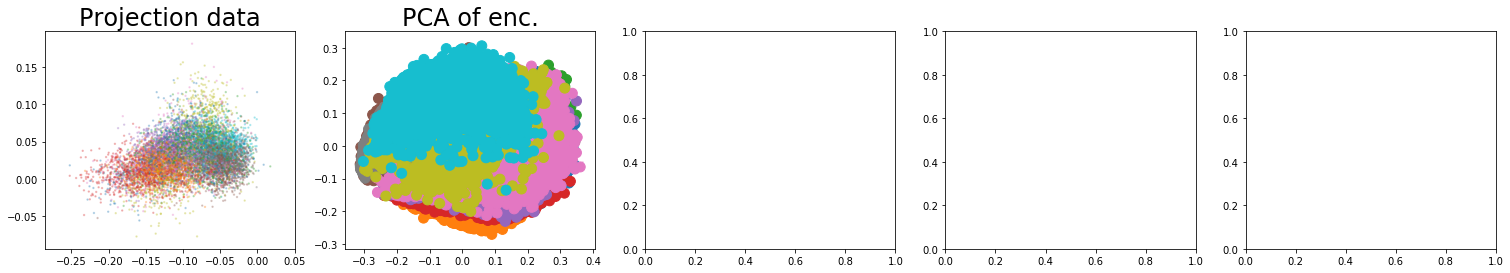

In [29]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [30]:
from tfumap.paths import MODEL_DIR

In [31]:
batch = 0; epoch = 0
N_EPOCHS = 10
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

In [32]:
# early stopping parameters
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement
best_saved_acc = 0 # best accuracy on valid data that has been checkpointed
best_saved_batch = 0 # batch number for last good batch
max_reinitialize_delta = .01 # minimum loss in accuracy resulting in reinitialized weights
plot_frequency = 2500 # how frequently to plot
save_frequency = 2500 # how frequently to save batches
early_stop = False
early_stopping = False
saving=False
# where to save checkpoints
cpt_path = MODEL_DIR / 'semisupervised' / dataset / datestring

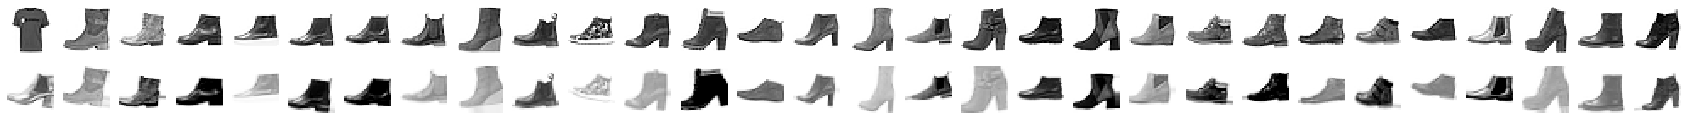

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator(
    rotation_range=10,       # random rotation degrees
    width_shift_range=0.1,   # random shift 10%
    height_shift_range=0.1,
    #horizontal_flip=True,
    brightness_range = (0.5, 1.5),
    #channel_shift_range = 0.5,
    shear_range = 0.05,
    zoom_range = 0.2,
    rescale=1./255,
)
nex = 30
X_train_copy = next(img_data_gen.flow(copy.deepcopy(X_train[-nex:]), shuffle=False, batch_size=len(X_train[-nex:])))
fig, axs = plt.subplots(ncols = nex, nrows=2, figsize=(nex, 2))
for i in range(nex):
    axs[0, i].matshow(np.squeeze(X_train[-i]), cmap=plt.cm.Greys, vmin=0, vmax=1)
    axs[1, i].matshow(np.squeeze(X_train_copy[-i]), cmap=plt.cm.Greys, vmin=0, vmax=1)
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [34]:
### randomly shift X_train_copy...

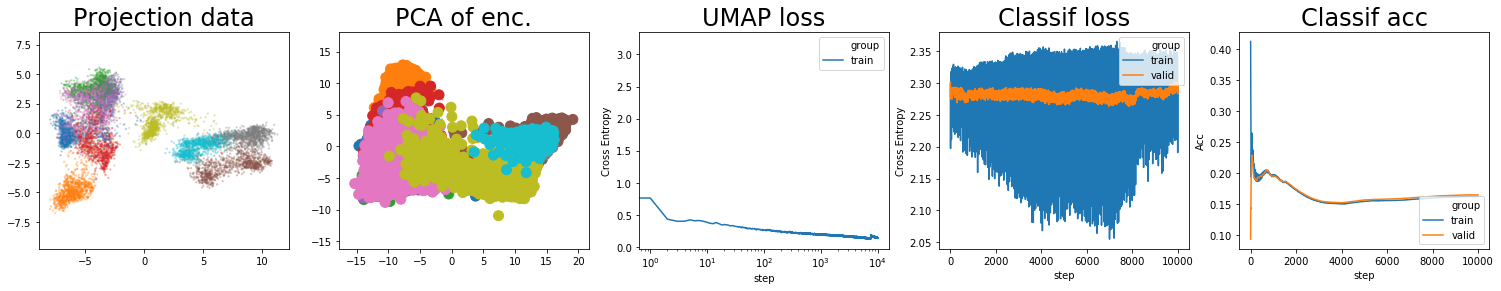

batch: 10000 | train acc: 0.1624 | val acc: 0.165


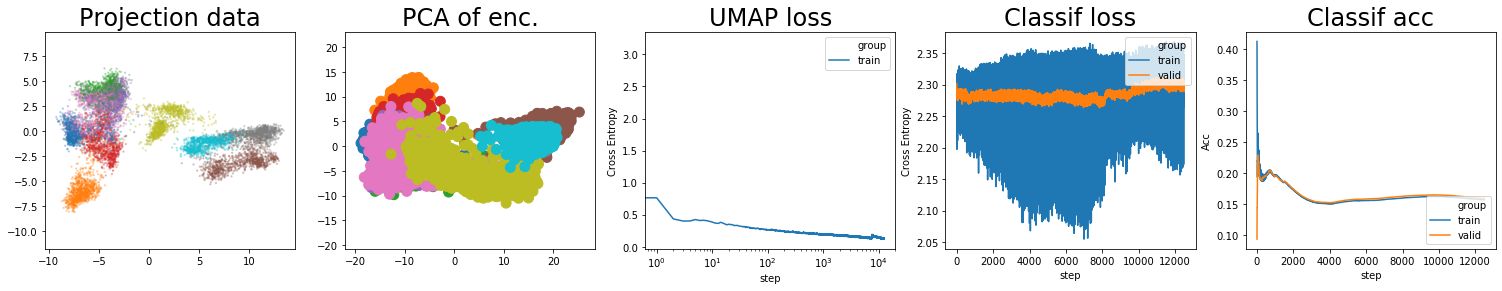

batch: 12500 | train acc: 0.1572 | val acc: 0.1595


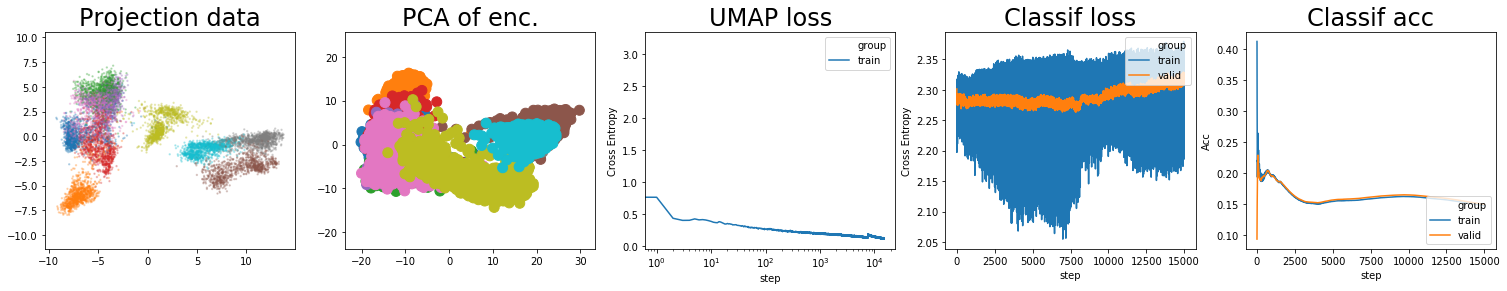

batch: 15000 | train acc: 0.1478 | val acc: 0.1498


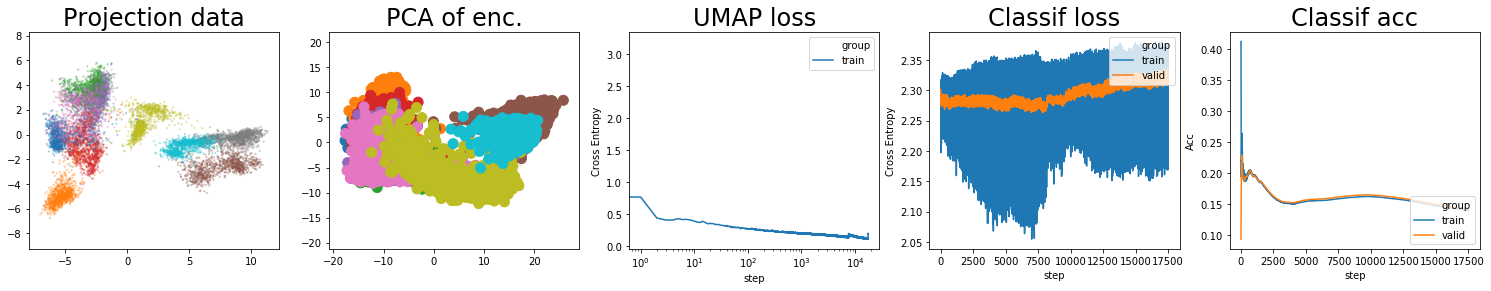

batch: 17500 | train acc: 0.14 | val acc: 0.142


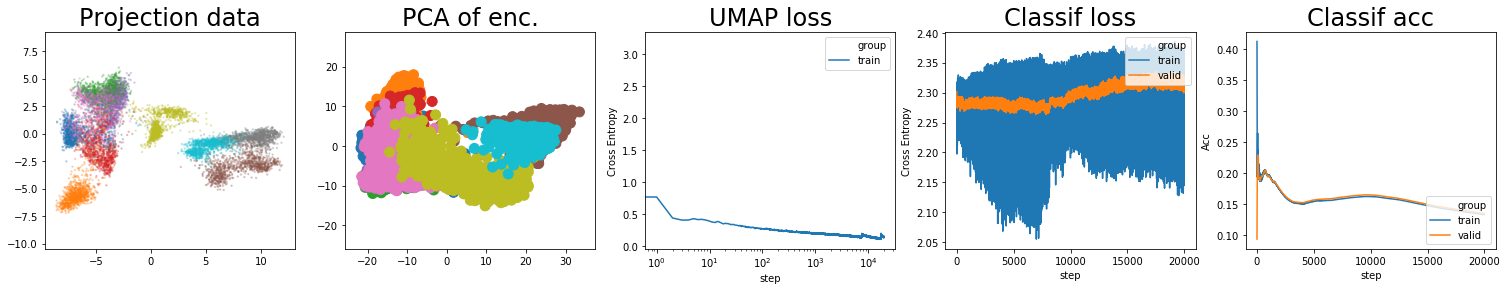

batch: 20000 | train acc: 0.1336 | val acc: 0.1353


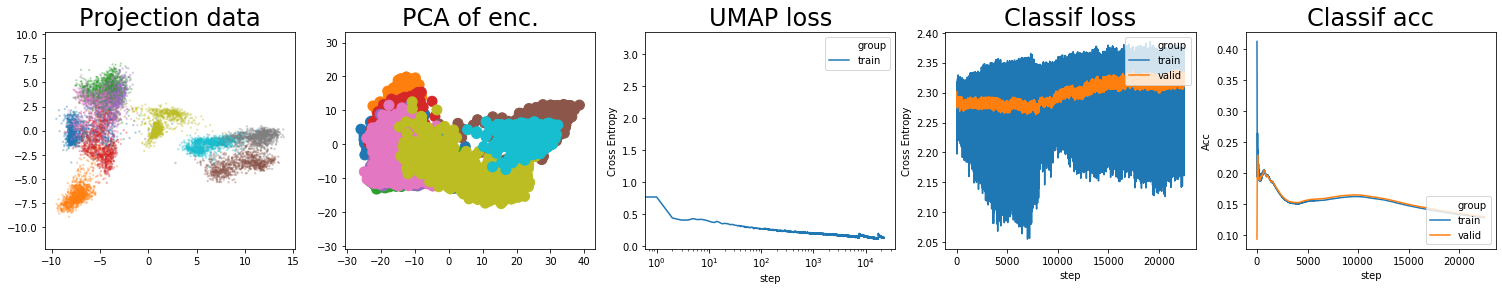

batch: 22500 | train acc: 0.1285 | val acc: 0.13


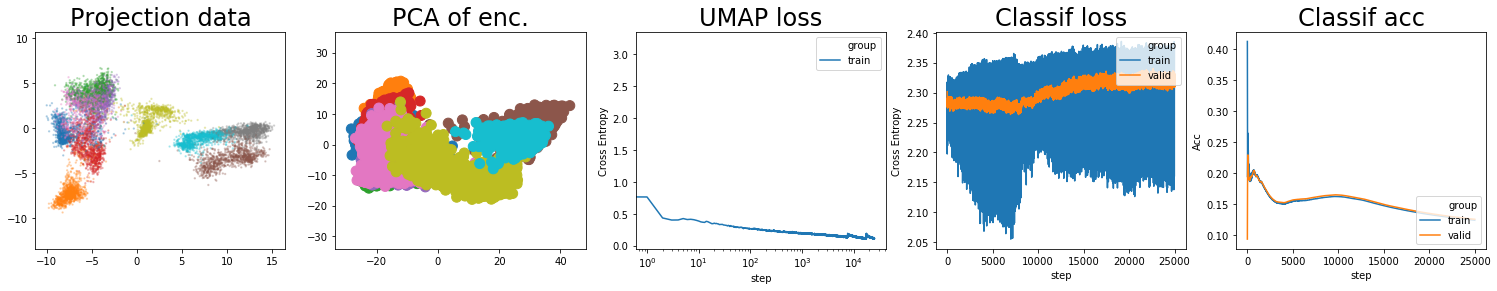

batch: 25000 | train acc: 0.1246 | val acc: 0.1259


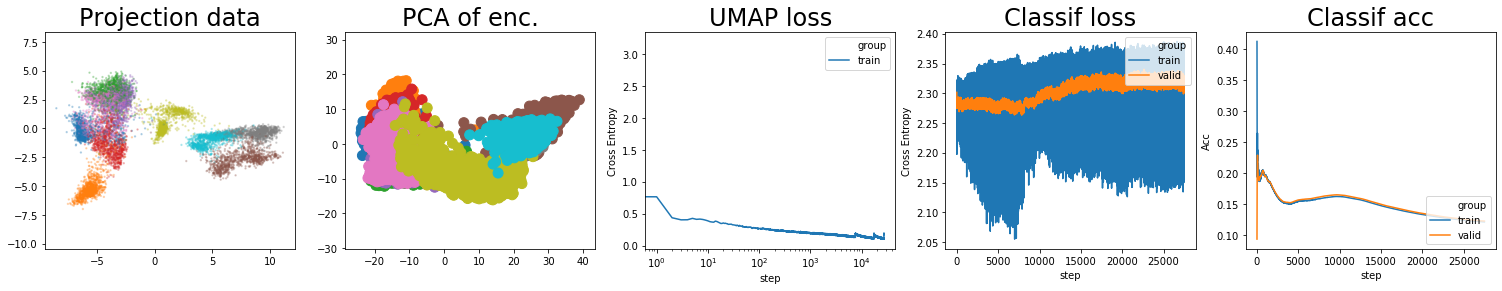

batch: 27500 | train acc: 0.1218 | val acc: 0.1231


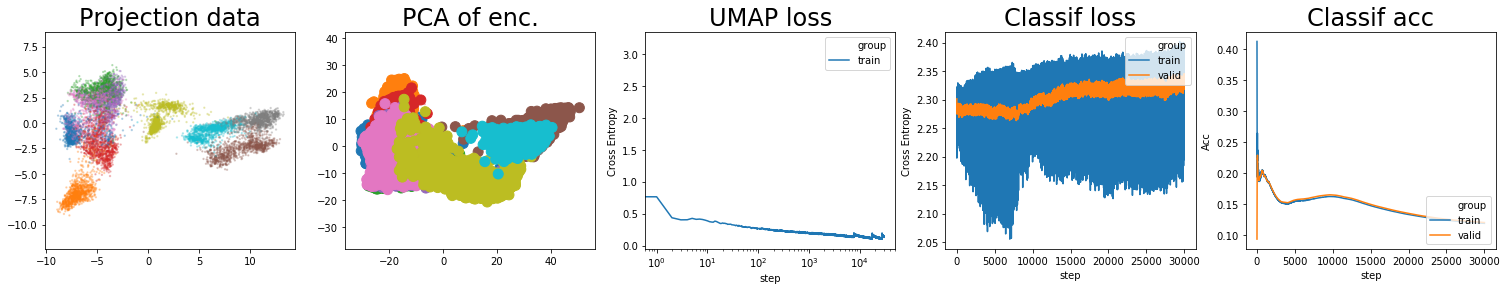

batch: 30000 | train acc: 0.1194 | val acc: 0.1207


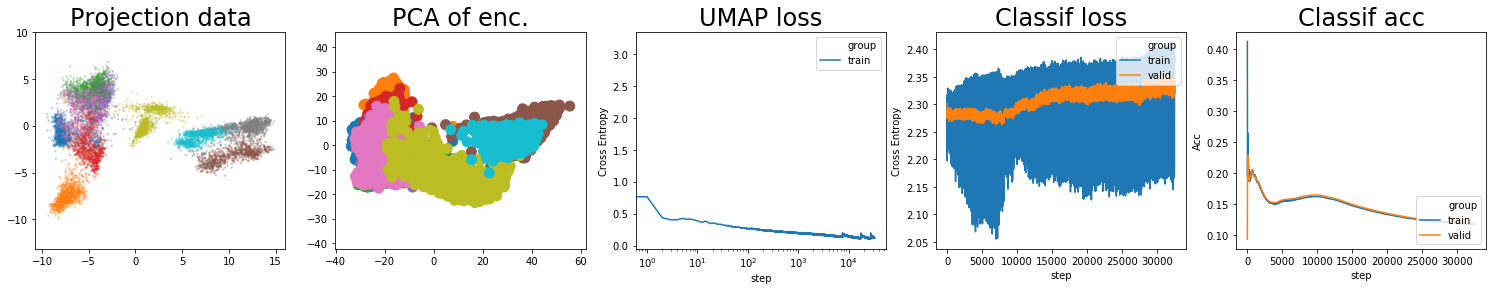

batch: 32500 | train acc: 0.1175 | val acc: 0.1189


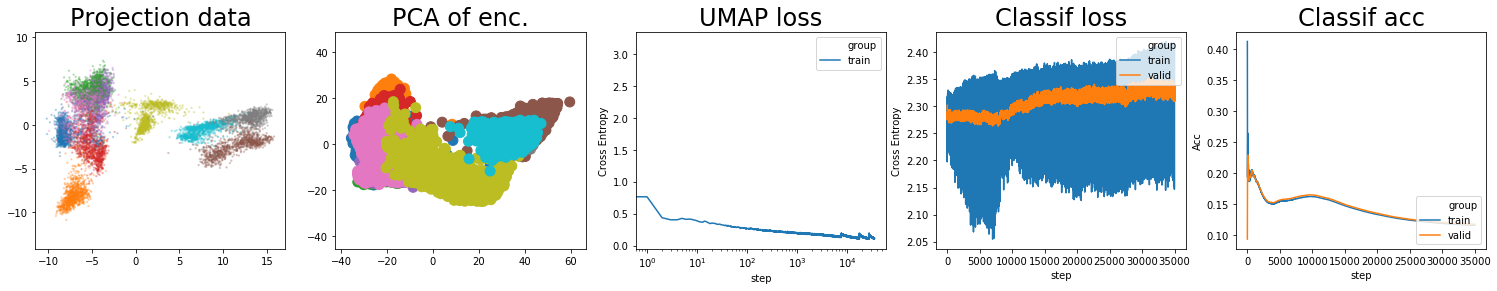

batch: 35000 | train acc: 0.1164 | val acc: 0.1179


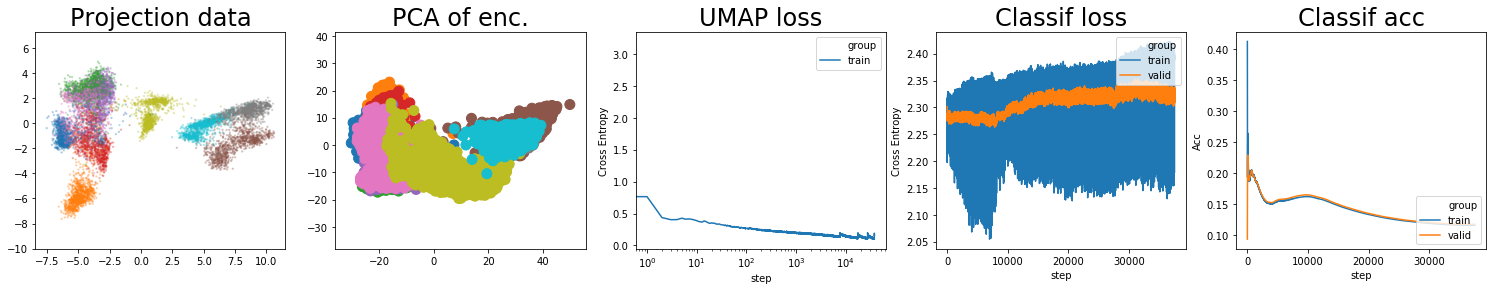

batch: 37500 | train acc: 0.1163 | val acc: 0.1178


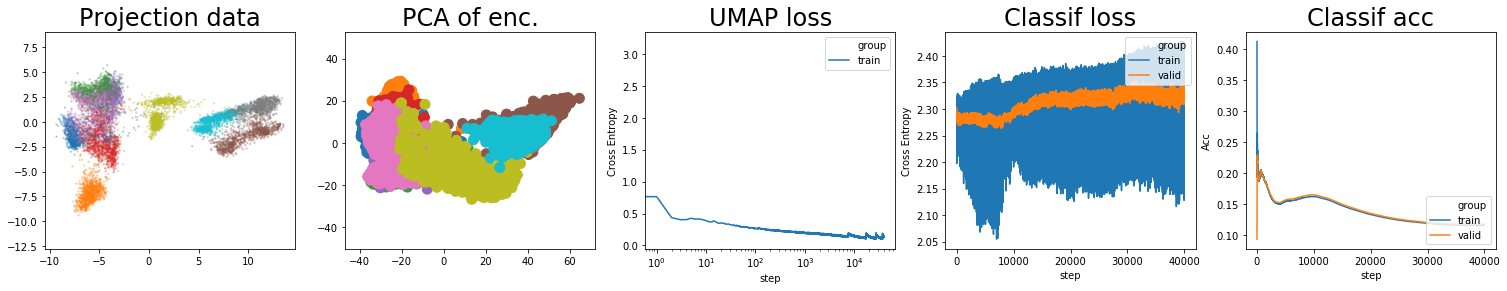

batch: 40000 | train acc: 0.1163 | val acc: 0.1178


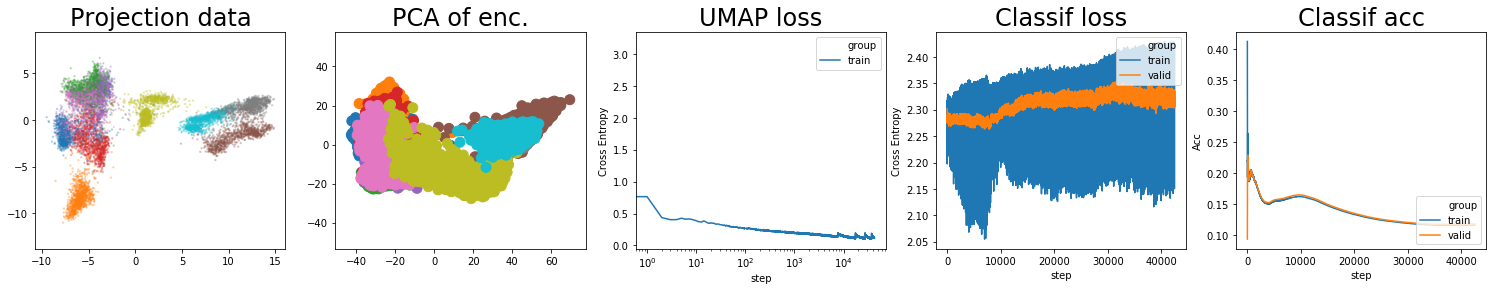

batch: 42500 | train acc: 0.1167 | val acc: 0.1182


KeyboardInterrupt: 

In [41]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    # augment data
    X_train_copy = next(img_data_gen.flow(copy.deepcopy(X_train), shuffle=False, batch_size=len(X_train)))
    #X_train_copy = X_train
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False
    ):
        
        
        # print(type(X))
        batch_to = X_train_copy[batch_to]
        batch_from = X_train_copy[batch_from]
        # batch_to = tf.Tensor(next(img_data_gen.flow(X_train[batch_to], shuffle=False, batch_size=len(batch_to))))
        # batch_from = next(img_data_gen.flow(X_train[batch_from], shuffle=False, batch_size=len(batch_to)))
        # X = next(img_data_gen.flow(X, shuffle=False, batch_size=len(X)))
        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(batch_to=batch_to, batch_from=batch_from, X=X, y=y)

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )

        # plot results
        if batch % plot_frequency == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "batch: {} | train acc: {} | val acc: {}".format(
                    str(batch),
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )

        if saving:
            #### save network
            if batch % save_frequency == 0:
                print(val_acc, (best_saved_acc - max_reinitialize_delta))
                if val_acc > best_saved_acc:
                    # save weights
                    print("saving weights")
                    model.encoder.save_weights((cpt_path / "encoder").as_posix())
                    model.embedder.save_weights((cpt_path / "embedder").as_posix())
                    model.classifier.save_weights((cpt_path / "classifier").as_posix())
                    best_saved_acc = val_acc.numpy()
                    # save batch number
                    best_saved_batch = copy.deepcopy(batch)

                elif val_acc < (best_saved_acc - max_reinitialize_delta):
                    # reload weights
                    print("reloading weights")
                    model.encoder.load_weights((cpt_path / "encoder").as_posix())
                    model.embedder.load_weights((cpt_path / "embedder").as_posix())
                    model.classifier.load_weights((cpt_path / "classifier").as_posix())

                    # reset batch
                    batch = copy.deepcopy(best_saved_batch)
                    # reset optimizer
                    for var in model.optimizer.variables():
                        var.assign(tf.zeros_like(var))

                    # continue on with newly updated batch (past early stopping)
                    continue

        if early_stopping:
            #### early stopping
            # if there is an imporovement, set new best score
            if val_acc > best_acc + min_delta:
                last_improvement = 0
                best_acc = val_acc
            else:
                # if model has not improved and patience has been surpassed, quit
                if last_improvement >= patience:
                    print("Early stopping")
                    early_stop = True
                    break
                else:
                    last_improvement += 1

        batch += 1
    if early_stop:
        break

In [42]:
from tfumap.semisupervised_plotting import embed_data

In [43]:
z_valid = embed_data(X_valid, model, batch_size)
z_train = embed_data(X_train, model, batch_size)

In [44]:
z_train.shape

(50000, 2)

(-11.329870503094035, 17.6589234282039, -12.265086051240576, 7.86194216848911)

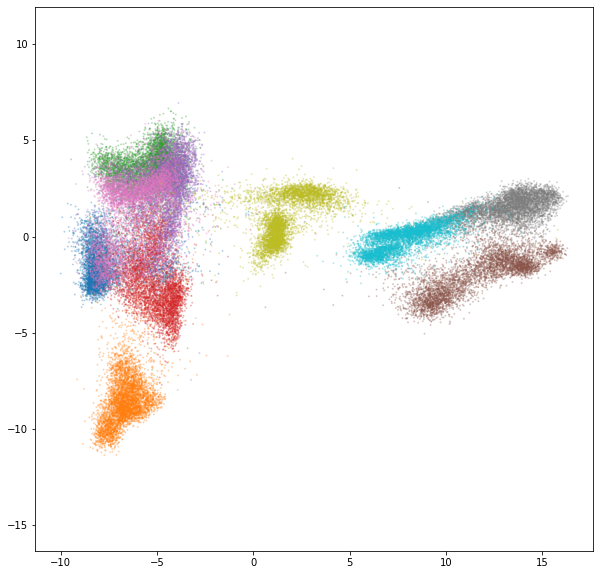

In [45]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.scatter(
    z_train[:, 0],
    z_train[:, 1],
    c=Y_train,
    cmap=plt.cm.tab10,  # "tab10"
    s=1,
    alpha=0.25,
    rasterized=True,
)
ax.axis('equal')

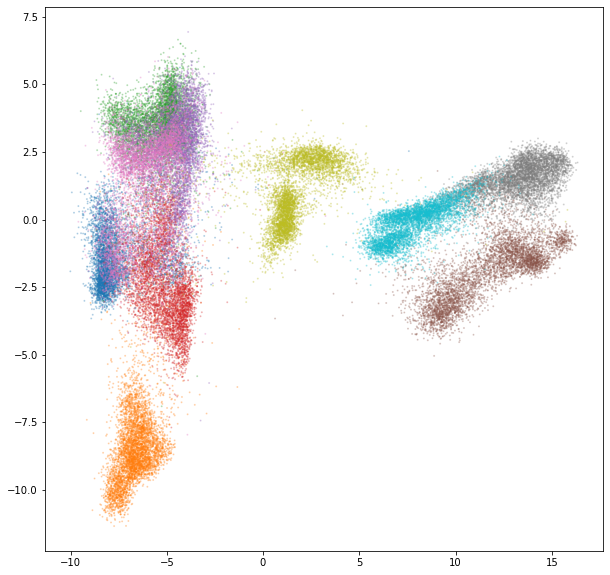

In [47]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.scatter(
    z_train[:, 0],
    z_train[:, 1],
    c=Y_train,
    cmap=plt.cm.tab10,  # "tab10"
    s=1,
    alpha=0.25,
    rasterized=True,
)
#ax.axis('equal')

In [ ]:
batch_to.shape, batch_from.shape, X.shape

In [ ]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

In [ ]:
loss_df.to_pickle(cpt_path/'loss_df')

In [ ]:
valid_acc = loss_df[
    (loss_df.group.values == "valid") & (loss_df.variable.values == "classif_acc")
].val.values

In [ ]:
plt.plot(valid_acc)